# Obj Detection

## Loading DataSet

In [ ]:
!wget http://horatio.cs.nyu.edu/mit/silberman/nyu_depth_v2/nyu_depth_v2_labeled.mat

## Loading Weights of YoloV3

In [ ]:
!wget https://pjreddie.com/media/files/yolov3.weights

## Importing Libraries

In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy.io
import scipy.misc
import PIL
import struct
import cv2
from numpy import expand_dims
import tensorflow as tf
from skimage.transform import resize
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D
from keras.models import load_model, Model
from keras.layers.merge import add, concatenate
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib.patches import Rectangle
from matplotlib import pyplot
import matplotlib
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
!pip install mat73
import mat73
%matplotlib inline
import sys
sys.path.insert(0,'/content/drive/My Drive')

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
mat = mat73.loadmat('./nyu_depth_v2_labeled.mat')

ERROR:root:ERROR: MATLAB type not supported: containers.Map, (uint32)


## Loading and saving Data

In [ ]:
ids = mat['namesToIds']
np.save('/content/drive/My Drive/ids.npy', ids)

In [ ]:
depths = mat['depths']
images = mat['images']
labels = mat['labels']
names  = mat['names'] 

depths = depths.transpose(2, 0, 1)
images = images.transpose(3, 0, 1, 2)
labels = labels.transpose(2, 0, 1)

In [ ]:
np.save('/content/drive/My Drive/depths.npy', depths)
np.save('/content/drive/My Drive/images.npy', images)
np.save('/content/drive/My Drive/labels.npy', labels)
np.save('/content/drive/My Drive/name.npy', names)

In [ ]:
depths = np.load('/content/drive/My Drive/depths.npy')
images = np.load('/content/drive/My Drive/images.npy')
labels2 = np.load('/content/drive/My Drive/labels.npy')
names =   np.load('/content/drive/My Drive/name.npy')

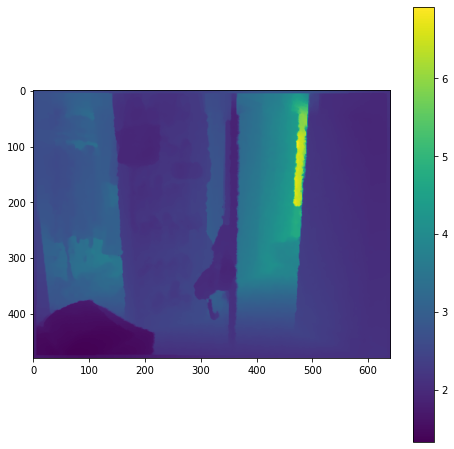

In [ ]:
fig, ax = plt.subplots(figsize = (8, 8))

gg = plt.imshow(depths[1009])
fig.colorbar(gg, ax=ax)

## Implementing YoloV3

### reading pretrained weights of YoloV3

In [ ]:
class WeightReader:
	def __init__(self, weight_file):
		with open(weight_file, 'rb') as w_f:
			major,	= struct.unpack('i', w_f.read(4))
			minor,	= struct.unpack('i', w_f.read(4))
			revision, = struct.unpack('i', w_f.read(4))
			if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
				w_f.read(8)
			else:
				w_f.read(4)
			transpose = (major > 1000) or (minor > 1000)
			binary = w_f.read()
		self.offset = 0
		self.all_weights = np.frombuffer(binary, dtype='float32')
 
	def read_bytes(self, size):
		self.offset = self.offset + size
		return self.all_weights[self.offset-size:self.offset]
 
	def load_weights(self, model):
		for i in range(106):
			try:
				conv_layer = model.get_layer('conv_' + str(i))
				print("loading weights of convolution #" + str(i))
				if i not in [81, 93, 105]:
					norm_layer = model.get_layer('bnorm_' + str(i))
					size = np.prod(norm_layer.get_weights()[0].shape)
					beta  = self.read_bytes(size) # bias
					gamma = self.read_bytes(size) # scale
					mean  = self.read_bytes(size) # mean
					var   = self.read_bytes(size) # variance
					weights = norm_layer.set_weights([gamma, beta, mean, var])
				if len(conv_layer.get_weights()) > 1:
					bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
					kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
					kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
					kernel = kernel.transpose([2,3,1,0])
					conv_layer.set_weights([kernel, bias])
				else:
					kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
					kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
					kernel = kernel.transpose([2,3,1,0])
					conv_layer.set_weights([kernel])
			except ValueError:
				print("no convolution #" + str(i))
 
	def reset(self):
		self.offset = 0

### Creating Structure of network

In [ ]:
def _conv_block(inp, convs, skip=True):
	x = inp
	count = 0
	for conv in convs:
		if count == (len(convs) - 2) and skip:
			skip_connection = x
		count += 1
		if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
		x = Conv2D(conv['filter'],
				   conv['kernel'],
				   strides=conv['stride'],
				   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
				   name='conv_' + str(conv['layer_idx']),
				   use_bias=False if conv['bnorm'] else True)(x)
		if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
		if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
	return add([skip_connection, x]) if skip else x

def make_yolov3_model():
	input_image = Input(shape=(None, None, 3))
	# Layer  0 => 4
	x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
								  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
								  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
								  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
	# Layer  5 => 8
	x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
						{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
						{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
	# Layer  9 => 11
	x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
						{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
	# Layer 12 => 15
	x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
						{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
						{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
	# Layer 16 => 36
	for i in range(7):
		x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
							{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
	skip_36 = x
	# Layer 37 => 40
	x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])
	# Layer 41 => 61
	for i in range(7):
		x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
							{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
	skip_61 = x
	# Layer 62 => 65
	x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
	# Layer 66 => 74
	for i in range(3):
		x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
							{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
	# Layer 75 => 79
	x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
	# Layer 80 => 82
	yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
							  {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)
	# Layer 83 => 86
	x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
	x = UpSampling2D(2)(x)
	x = concatenate([x, skip_61])
	# Layer 87 => 91
	x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)
	# Layer 92 => 94
	yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
							  {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)
	# Layer 95 => 98
	x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
	x = UpSampling2D(2)(x)
	x = concatenate([x, skip_36])
	# Layer 99 => 106
	yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
							   {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)
	model = Model(input_image, [yolo_82, yolo_94, yolo_106])
	return model

### building model

In [ ]:
yolov3 = make_yolov3_model()

# load the weights
weight_reader = WeightReader('/content/drive/My Drive/yolov3.weights')

# set the weights
weight_reader.load_weights(yolov3)

# save the model to file
#yolov3.save('model.h5')

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

## Loading  Images

In [ ]:
def load_image_pixels(filename, shape):
  # load image to get its shape
  image = load_img(filename)
  width, height = image.size

  # load image with required size
  image = load_img(filename, target_size=shape)
  image = img_to_array(image)

  # grayscale image normalization
  image = image.astype('float32')
  image /= 255.0

  # add a dimension so that we have one sample
  image = expand_dims(image, 0)
  return image, width, height


def load_image_pixels2(filename, shape):
  # load image to get its shape
  image = load_img(filename)
  width, height = image.size

  # load image with required size
  image = load_img(filename, target_size=shape)
  image = img_to_array(image)

  # grayscale image normalization
  image = image.astype('float32')
  image /= 255.0

  # add a dimension so that we have one sample
  image = expand_dims(image, 0)
  return image

## Class for bounding boxes

In [ ]:
class BoundBox:
  def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
    self.xmin = xmin
    self.ymin = ymin
    self.xmax = xmax
    self.ymax = ymax
    self.objness = objness
    self.classes = classes
    self.label = -1
    self.score = -1

  def get_label(self):
    if self.label == -1:
      self.label = np.argmax(self.classes)
    
    return self.label
  
  def get_score(self):
    if self.score == -1:
      self.score = self.classes[self.get_label()]
    return self.get_score

def _sigmoid(x):
  return 1. /(1. + np.exp(-x))

def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5
    boxes = []
    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh
 
    for i in range(grid_h*grid_w):
        row = i / grid_w
        col = i % grid_w
        for b in range(nb_box):
            # 4th element is objectness score
            objectness = netout[int(row)][int(col)][b][4]
            if(objectness.all() <= obj_thresh): continue
            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[int(row)][int(col)][b][:4]
            x = (col + x) / grid_w # center position, unit: image width
            y = (row + y) / grid_h # center position, unit: image height
            w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
            # last elements are class probabilities
            classes = netout[int(row)][col][b][5:]
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            boxes.append(box)
    return boxes

### Scaling Bounding Boxes

In [ ]:
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    new_w, new_h = net_w, net_h
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

### Removing overlaps of bounding boxes

In [ ]:
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3
 
def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect = intersect_w * intersect_h
    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    union = w1*h1 + w2*h2 - intersect
    return float(intersect) / union
 
def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] == 0: continue
            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]
                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
    v_boxes, v_labels, v_scores = list(), list(), list()
    # enumerate all boxes
    for box in boxes:
        # enumerate all possible labels
        for i in range(len(labels)):
            # check if the threshold for this label is high enough
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
                # don't break, many labels may trigger for one box
    return v_boxes, v_labels, v_scores

# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores, yhat, image):
  
    # load the image
    data = pyplot.imread(filename)
    # plot the image
    pyplot.imshow(data)
    # get the context for drawing boxes
    ax = pyplot.gca()
    err = [0]
    # plot each box
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        obj = yhat[y1: y2 , x1:x2]
        image_t = image[y1: y2 , x1:x2]
        err.append(mean_squared_error(obj, image_t, squared=False))
        mean = np.mean(obj)
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='green', linewidth = '2')
        # draw the box
        ax.add_patch(rect)
        # draw text and score in top left corner
        label = "%s (%.2f), (%.2f)" % (v_labels[i], v_scores[i], mean)
        pyplot.text(x1, y1, label, color='blue')
    err = np.nanmean(np.array(err))
		# show the plot
    pyplot.show()
    return err

In [ ]:
# This one is just for calculating error and not drawing boxes on picture
def draw_boxes2(filename, v_boxes, v_labels, v_scores, yhat, image):
  
    err = [0]
    # plot each box
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        obj = yhat[y1: y2 , x1:x2]
        image_t = image[y1: y2 , x1:x2]
        err.append(mean_squared_error(obj, image_t, squared=False))
    err = np.nanmean(np.array(err))
    return err


def draw_boxes3(filename, v_boxes, v_labels, v_scores, yhat):
  
    # load the image
    data = pyplot.imread(filename)
    # plot the image
    pyplot.imshow(data)
    # get the context for drawing boxes
    ax = pyplot.gca()
    # plot each box
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        obj = yhat[y1: y2 , x1:x2]
        mean = np.mean(obj)
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='green', linewidth = '2')
        # draw the box
        ax.add_patch(rect)
        # draw text and score in top left corner
        label = "%s (%.2f), (%.2f)" % (v_labels[i], v_scores[i], mean)
        pyplot.text(x1, y1, label, color='blue')
		# show the plot
    pyplot.show()

In [ ]:
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]

# define the probability threshold for detected objects
class_threshold = 0.35

# define the labels
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
	"boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
	"bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
	"backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
	"sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
	"tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
	"apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
	"chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
	"remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
	"book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

In [ ]:
collection = []
def obj_predaictor(photo_filename):

  # define the expected input shape for the model
  input_w, input_h = 416, 416

  image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
  # make prediction
  yhat = yolov3.predict(image)
  # summarize the shape of the list of arrays
  
  boxes = list() 
  for i in range(len(yhat)):
    # decode the output of the network
    boxes += decode_netout(yhat[i][0], anchors[i], 0.3, input_h, input_w)
 
  # correct the sizes of the bounding boxes for the shape of the image
  correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)

  # suppress non-maximal boxes
  do_nms(boxes, 0.5)

  # get the details of the detected objects
  v_boxes, v_labels, v_scores = get_boxes(boxes, labels, 0.3)
  
  return v_boxes, v_labels, v_scores
  
  # summarize what we found
  #for i in range(len(v_boxes)):
  #  print(v_labels[i], v_scores[i])
  
  # draw what we found
  #draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

In [ ]:
collection = np.load('/content/drive/My Drive/collection.npy', allow_pickle=True)

## Visualization for some of the data

  0%|          | 0/12 [00:00<?, ?it/s]

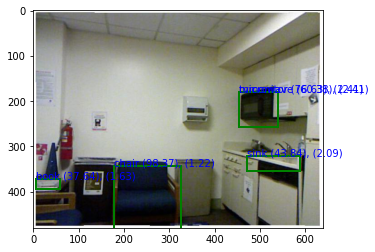

  8%|▊         | 1/12 [00:04<00:44,  4.01s/it]

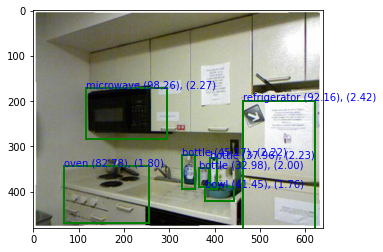

 17%|█▋        | 2/12 [00:08<00:40,  4.04s/it]

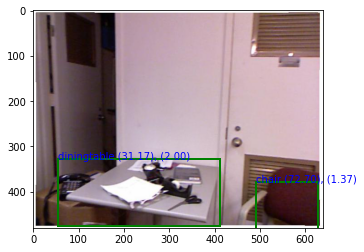

 25%|██▌       | 3/12 [00:11<00:35,  3.97s/it]

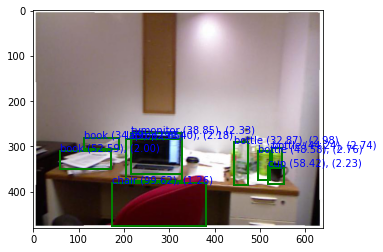

 33%|███▎      | 4/12 [00:16<00:32,  4.01s/it]

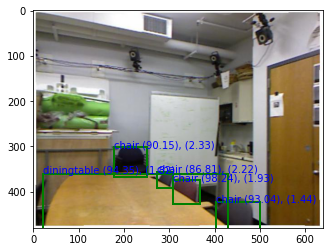

 42%|████▏     | 5/12 [00:19<00:27,  3.98s/it]

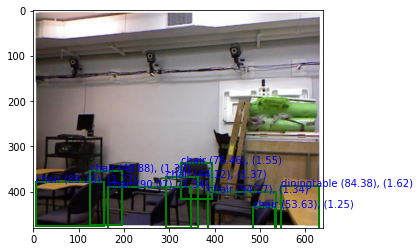

 50%|█████     | 6/12 [00:24<00:24,  4.02s/it]

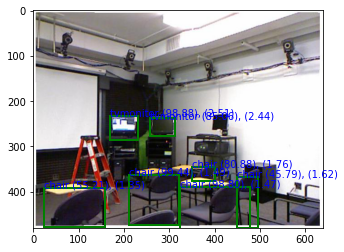

 58%|█████▊    | 7/12 [00:28<00:20,  4.03s/it]

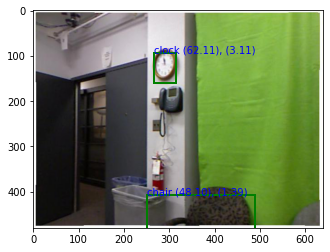

 67%|██████▋   | 8/12 [00:32<00:16,  4.06s/it]

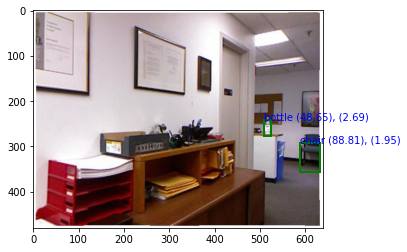

 75%|███████▌  | 9/12 [00:36<00:12,  4.03s/it]

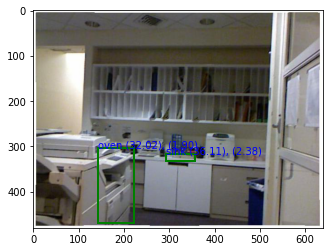

 83%|████████▎ | 10/12 [00:40<00:08,  4.01s/it]

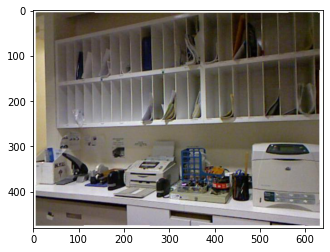

 92%|█████████▏| 11/12 [00:44<00:03,  3.97s/it]

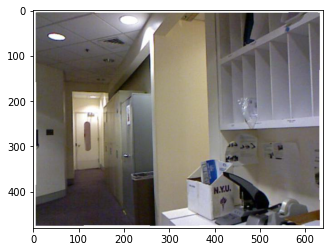

100%|██████████| 12/12 [00:47<00:00,  3.99s/it]


In [ ]:
indexs = np.arange(12)
error = []
for i in tqdm(range(12)):
  base = '/content/drive/My Drive/Images/'
  photo_filename =  'pic_'
  number = str(i)
  format = '.jpg'
  photo_filename =  base + photo_filename + number + format
  err = predictor(photo_filename, i)
  error.append(err)

## Total Error for all the images

In [ ]:
np.nanmean(np.array(error))

1.188327756524086

# Depth Estimation Model

## Imports and Loads

### Imports

In [ ]:
!pip install mat73

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv2D, ReLU, MaxPooling2D, Dropout, BatchNormalization, Dense, Flatten
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import categorical_crossentropy as CCE
from tensorflow.keras.utils import to_categorical as toCat
from matplotlib import pyplot as plt
from scipy.io import loadmat
import numpy as np
import pandas as pd
import cv2
from tensorflow.keras import layers
from tensorflow.keras.applications.densenet import preprocess_input
from tqdm import tqdm


### Loading the Dataset

In [ ]:
! wget http://horatio.cs.nyu.edu/mit/silberman/nyu_depth_v2/nyu_depth_v2_labeled.mat

--2022-02-03 17:54:25--  http://horatio.cs.nyu.edu/mit/silberman/nyu_depth_v2/nyu_depth_v2_labeled.mat
Resolving horatio.cs.nyu.edu (horatio.cs.nyu.edu)... 216.165.22.17
Connecting to horatio.cs.nyu.edu (horatio.cs.nyu.edu)|216.165.22.17|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2972037809 (2.8G)
Saving to: ‘nyu_depth_v2_labeled.mat’

nyu_depth_v2_labele 100%[===================>]   2.77G   996KB/s    in 53m 21s 

2022-02-03 18:47:47 (907 KB/s) - ‘nyu_depth_v2_labeled.mat’ saved [2972037809/2972037809]



In [ ]:
data_dict = mat73.loadmat('nyu_depth_v2_labeled.mat')
images_temp = data_dict['images']
depths_temp = data_dict['depths']

ERROR:root:ERROR: MATLAB type not supported: containers.Map, (uint32)


In [ ]:
images = np.zeros((1449, 480, 640, 3))
for i in range(1449):
    images[i] = images_temp[:, :, :, i] / 255
depths = np.zeros((1449, 480, 640))
for i in range(1449):
    depths[i] = depths_temp[:, :, i] / 10
del data_dict

In [ ]:
del images_temp, depths_temp

## Data Pipeline

### Hyper Parameters

In [ ]:
HEIGHT = 240
WIDTH = 320
LR = 0.0002
EPOCHS = 30
BATCH_SIZE = 32

### Generator

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, maps, batch_size=6, dim=(HEIGHT, WIDTH), n_channels=3, shuffle=True):

        
        self.images = images
        self.maps = maps
        self.indices = list(range(images.shape[0]))
        self.dim = dim
        self.n_channels = n_channels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, index): # Generate one batch of data
        if (index + 1) * self.batch_size > len(self.indices):
            self.batch_size = len(self.indices) - index * self.batch_size
        
        # Generate indices of the batch
        index = self.indices[index * self.batch_size : (index + 1) * self.batch_size]

        # Find list of IDs
        batch = [self.indices[k] for k in index]
        x, y = self.data_generation(batch)

        return x, y

    def on_epoch_end(self):

        # Updates indexes after each epoch
        
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def load(self, image, depth_map):

        # Loading the images
        
        image_ = image 
        image_ = cv2.resize(image_, (WIDTH, HEIGHT))
        image_ = tf.image.convert_image_dtype(image_, tf.float32)
        

        # Loading the maps

        depth_map = depth_map.squeeze()
        depth_map = cv2.resize(depth_map, (WIDTH, HEIGHT))
        depth_map = np.expand_dims(depth_map, axis=2)
        depth_map = tf.image.convert_image_dtype(depth_map, tf.float32)

        return image_, depth_map

    def data_generation(self, batch):

        x = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, 1))
        for i, batch_id in enumerate(batch):
            x[i,], y[i,] = self.load(
                self.images[batch_id],
                self.maps[batch_id],
            )
        return x, y


### Data Visualisation

In [ ]:
def visualize_depth_map(samples, test=False, model=None):
    input, target = samples
    cmap = plt.cm.jet
    cmap.set_bad(color="black")

    if test:
        pred = model.predict(input)
        fig, ax = plt.subplots(6, 3, figsize=(50, 50))
        for i in range(6):
            ax[i, 0].imshow((input[i].squeeze()))
            ax[i, 0].axis(False)
            ax[i, 0].set_title('Image')

            ax[i, 1].imshow((target[i].squeeze()), cmap=cmap)
            ax[i, 1].axis(False)
            ax[i, 1].set_title('Ground Truth')

            ax[i, 2].imshow((pred[i].squeeze()), cmap=cmap)
            ax[i, 2].axis(False)
            ax[i, 2].set_title('Predictoin')

    else:
        fig, ax = plt.subplots(6, 2, figsize=(50, 50))
        for i in range(6):
            ax[i, 0].imshow((input[i].squeeze()))
            ax[i, 0].axis(False)
            ax[i, 0].set_title('Image')

            ax[i, 1].imshow((target[i].squeeze()), cmap=cmap)
            ax[i, 1].axis(False)
            ax[i, 1].set_title('Ground Truth')



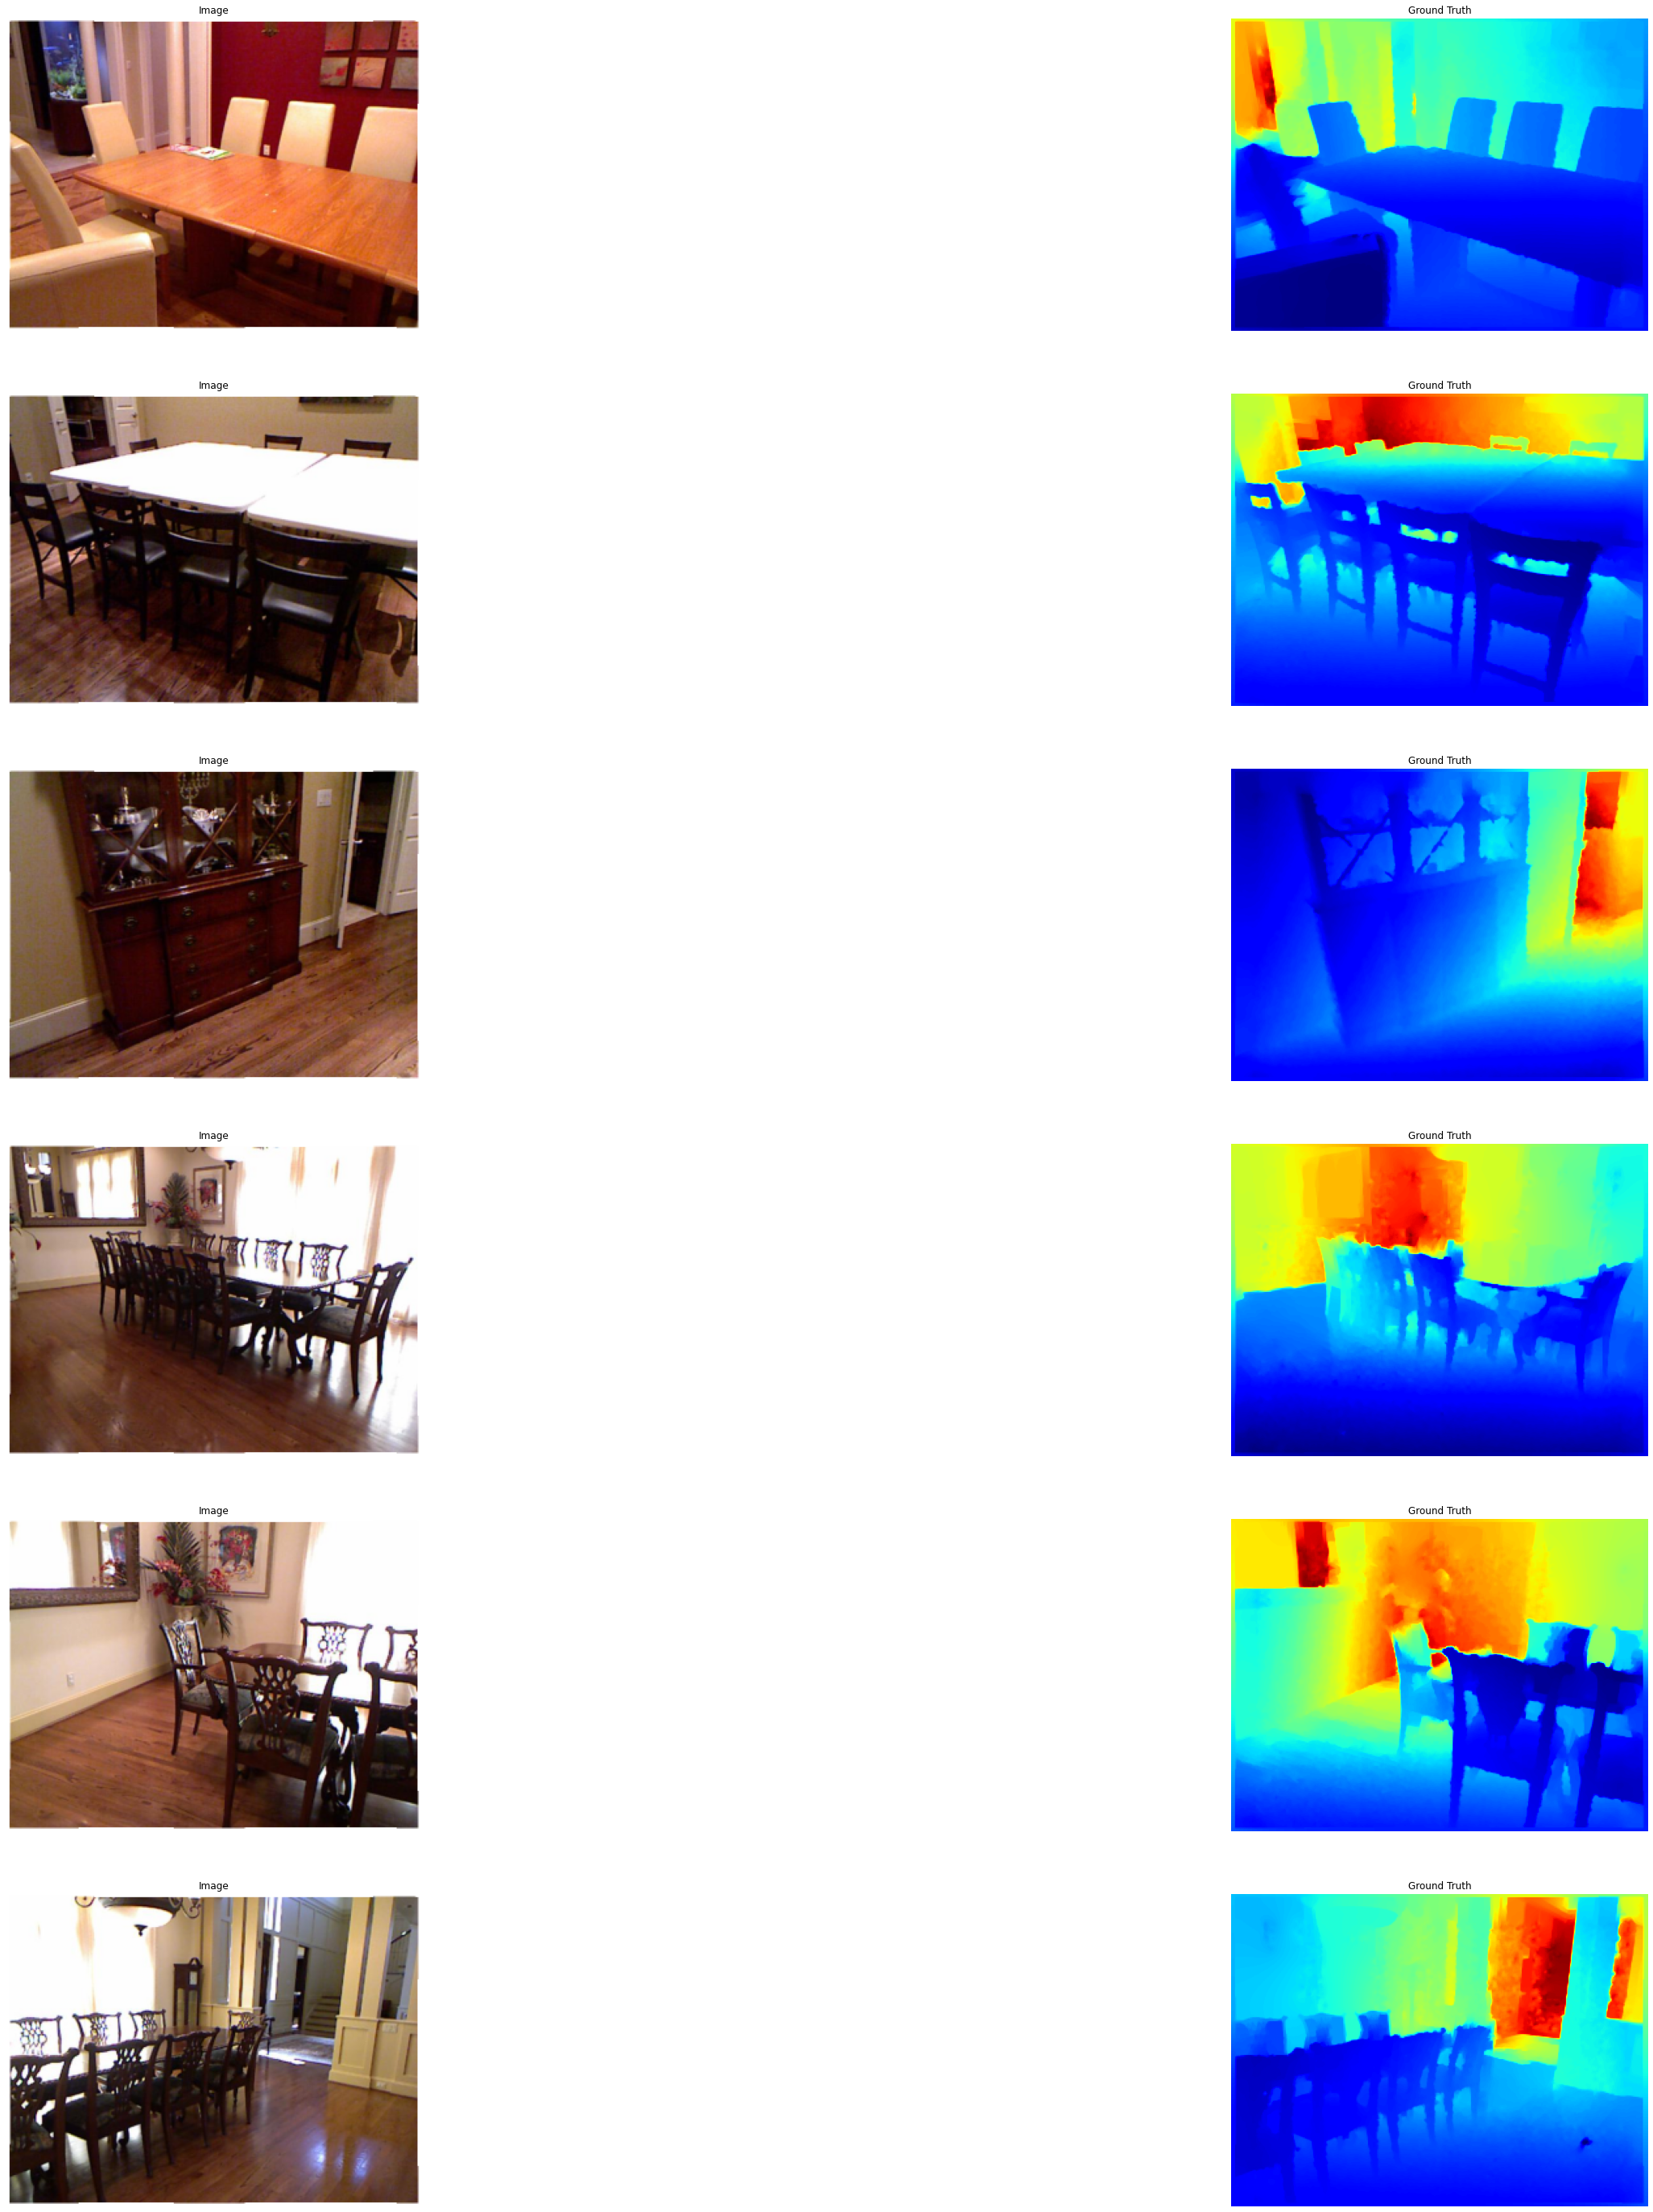

In [ ]:
test_loader = next(
    iter(
        DataGenerator(
            images=images[1400:], maps= depths[1400:], batch_size=6, dim=(HEIGHT, WIDTH)
        )
    )
)
visualize_depth_map(test_loader)


## Model Definition

### Layers

In [ ]:
class DownscaleBlock(layers.Layer):

    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)
        self.bn2a = tf.keras.layers.BatchNormalization()
        self.bn2b = tf.keras.layers.BatchNormalization()

        self.pool = layers.MaxPool2D((2, 2), (2, 2))

    def call(self, input_tensor):
        d = self.convA(input_tensor)
        x = self.bn2a(d)
        x = self.reluA(x)

        x = self.convB(x)
        x = self.bn2b(x)
        x = self.reluB(x)

        x += d
        p = self.pool(x)
        return x, p


class UpscaleBlock(layers.Layer):

    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.us = layers.UpSampling2D((2, 2))
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)
        self.bn2a = tf.keras.layers.BatchNormalization()
        self.bn2b = tf.keras.layers.BatchNormalization()
        self.conc = layers.Concatenate()

    def call(self, x, skip):
        x = self.us(x)
        concat = self.conc([x, skip])
        x = self.convA(concat)
        x = self.bn2a(x)
        x = self.reluA(x)

        x = self.convB(x)
        x = self.bn2b(x)
        x = self.reluB(x)

        return x


class BottleNeckBlock(layers.Layer):
  
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)

    def call(self, x):
        x = self.convA(x)
        x = self.reluA(x)
        x = self.convB(x)
        x = self.reluB(x)
        return x


### Model and Loss

In [ ]:
class DepthEstimationModel(tf.keras.Model):

    def __init__(self):

        super().__init__()
        self.ssim_loss_weight = 0.85
        self.l1_loss_weight = 0.1
        self.edge_loss_weight = 0.9
        self.loss_metric = tf.keras.metrics.Mean(name="loss")
        f = [16, 32, 64, 128, 256]
        ################
        self.downscale_blocks = [
            DownscaleBlock(f[0]),
            DownscaleBlock(f[1]),
            DownscaleBlock(f[2]),
            DownscaleBlock(f[3]),
        ]
        ################
        self.bottle_neck_block = BottleNeckBlock(f[4])
        ################
        self.upscale_blocks = [
            UpscaleBlock(f[3]),
            UpscaleBlock(f[2]),
            UpscaleBlock(f[1]),
            UpscaleBlock(f[0]),
        ]
        ################
        self.conv_layer = layers.Conv2D(1, (1, 1), padding="same", activation="tanh")



    def calculate_loss(self, target, pred):
      
        # Edges
        dy_true, dx_true = tf.image.image_gradients(target)
        dy_pred, dx_pred = tf.image.image_gradients(pred)
        weights_x = tf.exp(tf.reduce_mean(tf.abs(dx_true)))
        weights_y = tf.exp(tf.reduce_mean(tf.abs(dy_true)))

        # Depth smoothness
        smoothness_x = dx_pred * weights_x
        smoothness_y = dy_pred * weights_y

        depth_smoothness_loss = tf.reduce_mean(abs(smoothness_x)) + tf.reduce_mean(
            abs(smoothness_y)
        )

        # Structural similarity (SSIM) index
        ssim_loss = tf.reduce_mean(
            1
            - tf.image.ssim(
                target, pred, max_val=WIDTH, filter_size=7, k1=0.01 ** 2, k2=0.03 ** 2
            )
        )
        # Point-wise depth
        l1_loss = tf.reduce_mean(tf.abs(target - pred))

        loss = (
            (self.ssim_loss_weight * ssim_loss)
            + (self.l1_loss_weight * l1_loss)
            + (self.edge_loss_weight * depth_smoothness_loss)
        )

        return loss

    @property
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, batch_data):
        input, target = batch_data
        with tf.GradientTape() as tape:
            pred = self(input, training=True)
            loss = self.calculate_loss(target, pred)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.loss_metric.update_state(loss)
        return {
            "loss": self.loss_metric.result(),
        }

    def test_step(self, batch_data):
        input, target = batch_data

        pred = self(input, training=False)
        loss = self.calculate_loss(target, pred)

        self.loss_metric.update_state(loss)
        return {
            "loss": self.loss_metric.result(),
        }

    def call(self, x):
        c1, p1 = self.downscale_blocks[0](x)
        c2, p2 = self.downscale_blocks[1](p1)
        c3, p3 = self.downscale_blocks[2](p2)
        c4, p4 = self.downscale_blocks[3](p3)

        bn = self.bottle_neck_block(p4)

        u1 = self.upscale_blocks[0](bn, c4)
        u2 = self.upscale_blocks[1](u1, c3)
        u3 = self.upscale_blocks[2](u2, c2)
        u4 = self.upscale_blocks[3](u3, c1)

        return self.conv_layer(u4)


In [ ]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LR,
    amsgrad=False,
)
model = DepthEstimationModel()
# Define the loss function
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)
# Compile the model
model.compile(optimizer, loss=cross_entropy)



## Train

### Generators

In [ ]:
train_loader = DataGenerator(
    images=images[:1400], maps= depths[:1400], batch_size=BATCH_SIZE, dim=(HEIGHT, WIDTH)
)
validation_loader = DataGenerator(
    images=images[1400:], maps= depths[1400:], batch_size=BATCH_SIZE, dim=(HEIGHT, WIDTH)
)

### Fit and saving

In [ ]:
history = model.fit(
                  train_loader,
                  epochs=15,
                  validation_data=validation_loader,
                  )

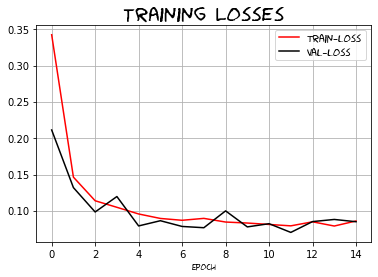

In [ ]:
plt.plot(history.history['loss'], 'r', label='train_loss')
plt.plot(history.history['val_loss'], 'k' , label='val_loss')
plt.grid(True)
plt.xlabel('epoch', fontsize=8, family= 'fantasy')   
plt.title('Training Losses', fontsize=20, family= 'fantasy')    
plt.legend(prop={'family': 'fantasy'})

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
# model.save('/content/gdrive/MyDrive/depth')

### Results

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
model = keras.models.load_model('/content/gdrive/MyDrive/depth')

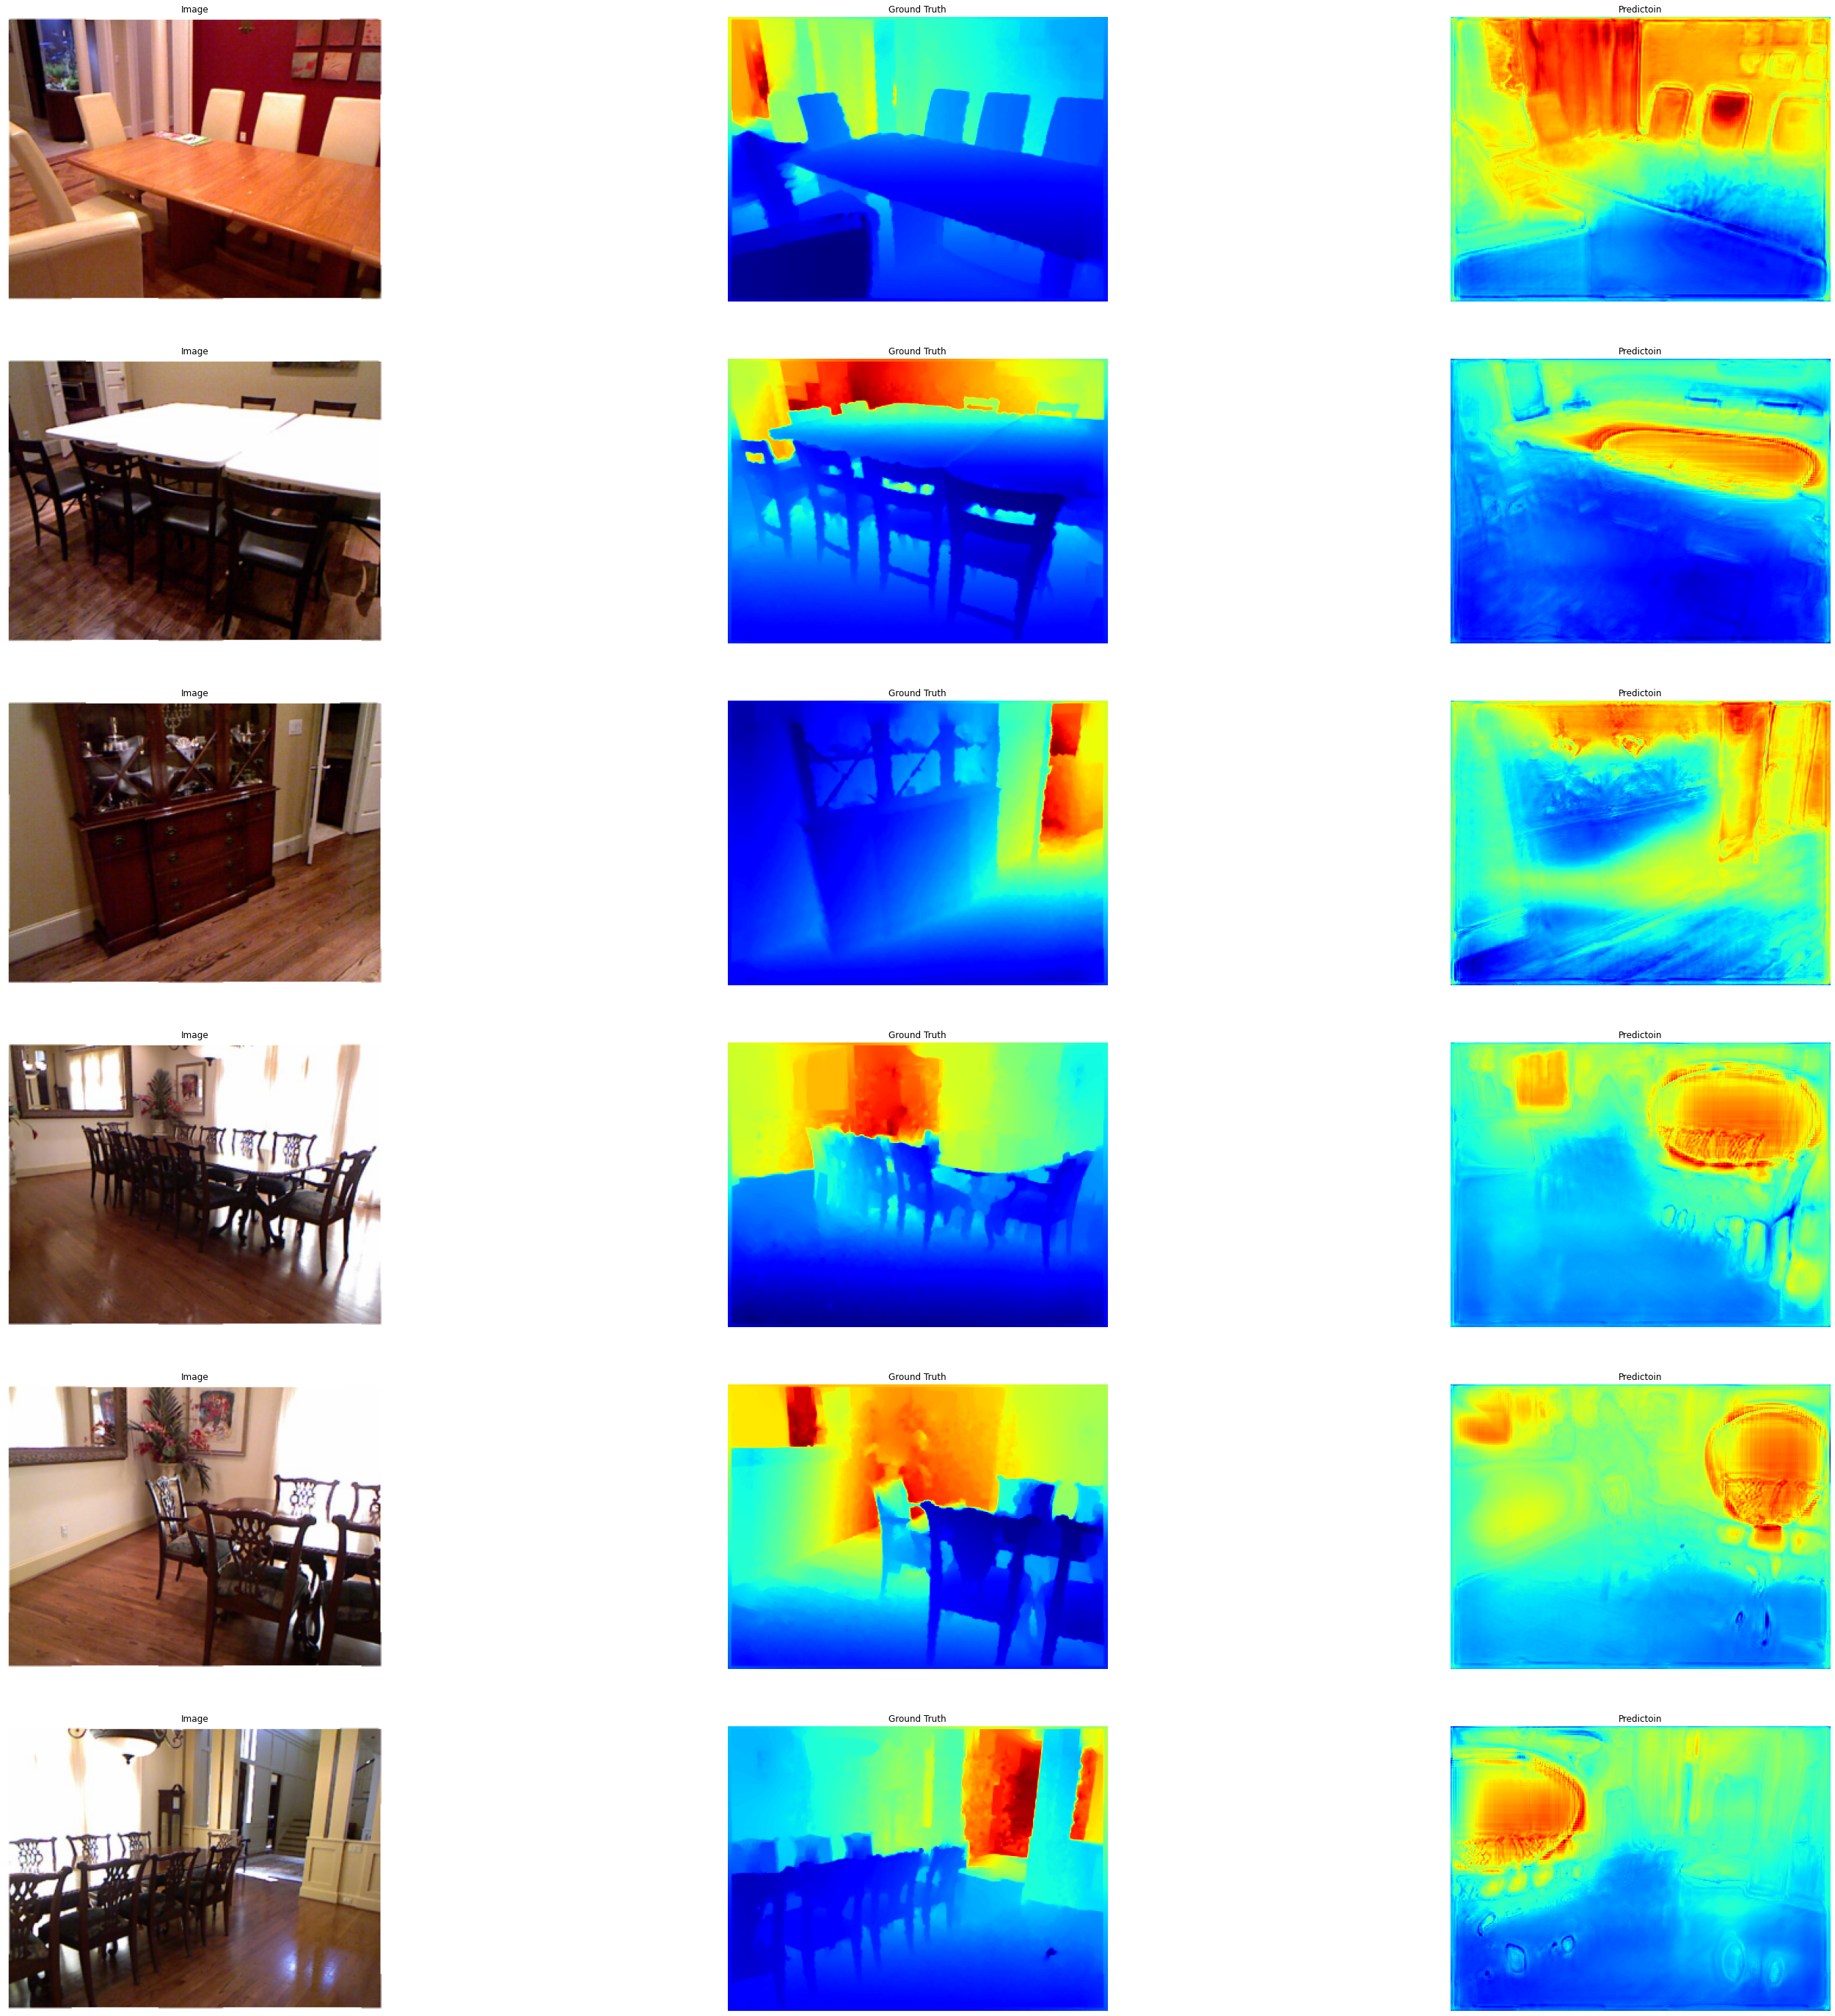

In [ ]:
test_loader = next(
    iter(
        DataGenerator(
            images=images[1400:], maps= depths[1400:], batch_size=6, dim=(HEIGHT, WIDTH)
        )
    )
)
visualize_depth_map(test_loader, test=True, model=model)


### Saving Numpy Maps

In [ ]:
loader = next(
    iter(
        DataGenerator(
            images=images, maps= depths, batch_size=1449, dim=(HEIGHT, WIDTH)
        )
    )
)

In [ ]:
del images, depths

In [ ]:
preds = model.predict(loader[0])

results = np.zeros((1449, 480, 640))

for i in tqdm(range(1449)):

    pred = preds[i]
    pred = cv2.resize(pred, (640, 480))
    pred = np.array(pred) 
    results[i] = pred

In [ ]:
with open('\content\gdrive\numpy\maps.npy', 'wb') as file:
    np.save(file, results)

## Loadings

### Model

In [ ]:
from google.colab import drive
from tensorflow import keras
import numpy as np
import tensorflow as tf


model = keras.models.load_model('/content/drive/My Drive/depth')

def depth(image):

    pred = model.predict(image)
    pred = pred.reshape((240, 320))
    pred = cv2.resize(pred, (640, 480))
    pred = np.array(pred) * 8
    return pred

def depth2(image, w, h):

    pred = model.predict(image)
    pred = pred.reshape((240, 320))
    pred = cv2.resize(pred, (h, w))
    pred = np.array(pred) * 8
    return pred

### Numpy Maps

In [ ]:
with open('\content\gdrive\numpy\maps.npy', 'rb') as file:
    maps = np.load(file)

# Predictor Function

In [ ]:
def predictor(photo_filename, i):
  v_boxes, v_labels, v_scores = obj_predaictor(photo_filename)
  input_w2, input_h2 = 240, 320
  image2  = load_image_pixels2(photo_filename, (input_w2, input_h2))
  yhat2 = depth(image2)

  err = draw_boxes(photo_filename, v_boxes, v_labels, v_scores, yhat2, depths[i])
  return err


# To just calculate the error
def predictor2(photo_filename, i):
  v_boxes, v_labels, v_scores = obj_predaictor(photo_filename)
  input_w2, input_h2 = 240, 320
  image2  = load_image_pixels2(photo_filename, (input_w2, input_h2))
  yhat2 = depth(image2)

  err = draw_boxes2(photo_filename, v_boxes, v_labels, v_scores, yhat2, depths[i])
  return err

def predictor3(photo_filename):
  v_boxes, v_labels, v_scores = obj_predaictor(photo_filename)
  a = load_img(photo_filename)
  w, h = a.size
  input_w2, input_h2 = 240, 320
  image2  = load_image_pixels2(photo_filename, (input_w2, input_h2))
  yhat2 = depth2(image2, w, h)

  draw_boxes3(photo_filename, v_boxes, v_labels, v_scores, yhat2)




In [ ]:
indexs = np.arange(12)
error = []
for i in tqdm(range(12)):
  base = '/content/drive/My Drive/Images/'
  photo_filename =  'pic_'
  number = str(i)
  format = '.jpg'
  photo_filename =  base + photo_filename + number + format
  err = predictor(photo_filename, i)
  error.append(err)

# Uploading picture yourself

In [ ]:
from google.colab import files
upload = files.upload()

Saving jj.jpg to jj (1).jpg


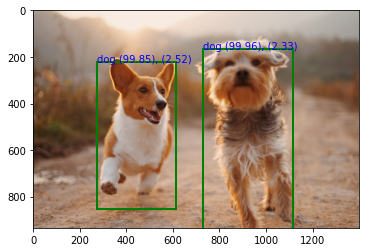

In [ ]:
for i in upload.keys():
  path = '/content/' + i
  predictor3(path)